# Remarks on dynamics of epidemiological models: Common features and an almost-linear trade-off between start and duration of distancing mandates
## Objective
This notebook is dedicated to understand how social distancing will effect the spread of an epidemic.
## Setup

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings
pyplot()

Plots.PyPlotBackend()

## Utility functions

In [2]:
# change plot fonts
bplot(p, s) = plot!(p, titlefont=font(s, "Times"), xguidefontsize=s-4
    , ytickfont=font(s-4, "Times"), margin=8mm, yguidefontsize=s-4
    , xtickfont = font(s-4, "Times"), legendfont = font(s-4, "Times"))

# this function will generate a T period of social distancing at time t0
sinput(t, ts, td) = if (t-ts<0 || t-ts-td>0) 0 else 1 end

sinput (generic function with 1 method)

# $SIR$ Model

## Basics

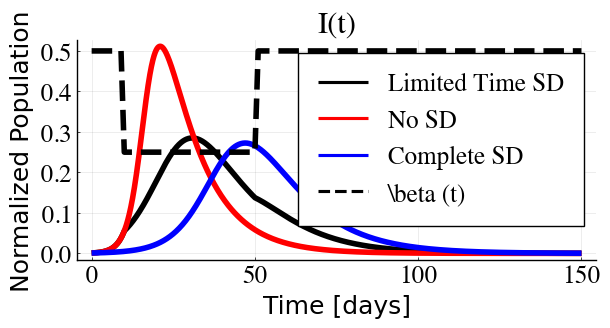

In [3]:
# model description
function SIR(dx,x,p,t)
    b, db, g, t0, T = p
    u = b - db.*sinput(t, t0, T)
    dx[1] = -u*x[1]*x[2]
    dx[2] = u*x[1]*x[2] - g*x[2]
    dx[3] = g*x[2]
end

beta  = 0.5
bdiff = 0.25
gamma = 0.09

# define initial values
u0 = [1-1e-3, 1e-3, 0.]
p  = [beta, bdiff, gamma, 10, 40]

# ode solver
alg = BS3()

# solve the ode problem
tspan = (0.0, 150)
prob  = ODEProblem(SIR, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)

# show something
fig = plot(sol.t, sol[2, :], linewidth=4, label="Limited Time SD", title="I(t)"
    , ylabel= "Normalized Population", xlabel= "Time [days]", c=:black)

p[4:5] = [0, 0]
prob  = ODEProblem(SIR, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timen = sol.t[argmax(sol[2,:])] # time of the peak
fig = plot!(fig, sol.t, sol[2, :], linewidth=4, label="No SD", c=:red)

p[4:5] = [0, 5e2]
prob  = ODEProblem(SIR, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timec = sol.t[argmax(sol[2,:])] # time of the peak
fig = plot!(fig, sol.t, sol[2, :], linewidth=4, label="Complete SD", c=:blue)

# what was the input?
x = 0:150
y = 0.5 .- 0.25* sinput.(x, 10, 40)
fig = plot!(fig, x, y, linewidth=4, label="\\beta (t)", size=(650,370), line=:dash, c=:black)
fig = bplot(fig, 22)

savefig(fig, "figures/SIR-1d.svg")

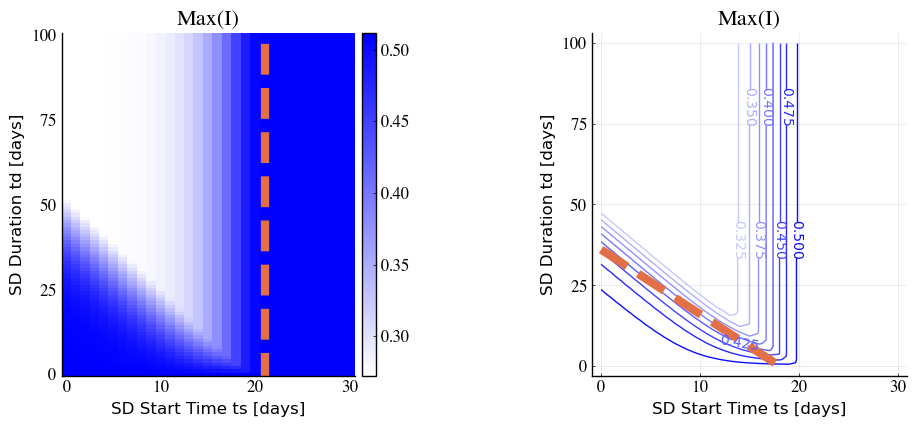

In [4]:
# range of the quarantine starting time and duration
Trng = 0:100 
trng = 0:30
data = zeros(size(Trng,1), size(trng,1))
time = data

# define initial values
u0 = [1-1e-3, 1e-3, 0.]
tspan = (0.0, 1e3)

for i = 1:size(Trng,1)
    for j = 1:size(trng,1)
        # solve the ode problem
        p[4:5] = [trng[j], Trng[i]]
        prob = ODEProblem(SIR, u0, tspan, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        data[i,j] = maximum(sol[2,:])
    end
end

p1 = heatmap(trng, Trng, data,c=cgrad([:white, :blue]),
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)")
p1 = plot!(p1, [Int(round(timen))], seriestype="vline", line=:dash, linewidth=6, legend=:false)
p1 = bplot(p1, 16)
savefig(p1, "figures/SIR_heatmap.svg")

p2 = contour(trng, Trng, data,c=cgrad([:white, :blue]), colorbar = false,
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)", contour_labels = true, linewidth=1, 
    levels=[0.325, 0.35, 0.375, 0.40, 0.425, 0.45, 0.475, 0.50])
x = 0:18; y = -2*x.+36
p2 = plot!(p2, x, y, linewidth=6, line=:dash, legend=:false)
p2 = bplot(p2, 16)
savefig(p2, "figures/SIR_contour.svg")

fig = plot(p1, p2, layout=(1,2), size=(960,470))
savefig(fig, "figures/SIR.svg")

# $SAIR$ Model

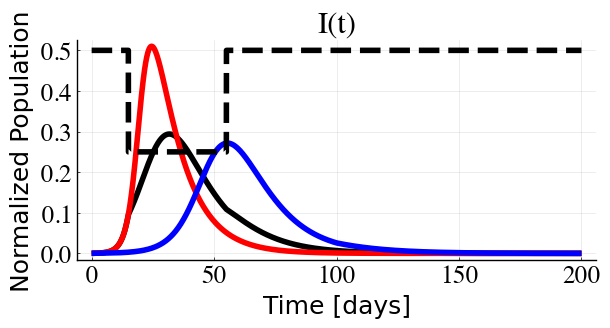

In [5]:
# model description
function SAIR(dx,x,p,t)
    b1, db1, b2, db2, nu, al, g, t0, T = p
    u1 = b1 - db1.*sinput(t, t0, T)
    u2 = b2 - db2.*sinput(t, t0, T)
    dx[1] = -u1*x[1]*x[2] - u2*x[1]*x[3]
    dx[2] = u1*x[1]*x[2] - (al+nu)*x[2]
    dx[3] = u2*x[1]*x[3] + nu*x[2]- g*x[3]
    dx[4] = al*x[2] + g*x[3]
end


# define initial values
u0 = [1-11e-4, 1e-3, 1e-4, 0.]
p  = [0.3, 0.15, 0.5, 0.25, 0.1, 0.5, 0.09, 15, 40]

# ode solver
alg = BS3()

# solve the ode problem
tspan = (0.0, 2e2)
prob  = ODEProblem(SAIR, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)

# show something
fig = plot(sol.t, sol[3, :], linewidth=4, title="I(t)"
    , ylabel= "Normalized Population", xlabel= "Time [days]", c=:black)

p[8:9] = [0, 0]
prob  = ODEProblem(SAIR, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timen = sol.t[argmax(sol[3,:])]
fig = plot!(fig, sol.t, sol[3, :], linewidth=4, c=:red)

p[8:9] = [0, 100.]
prob  = ODEProblem(SAIR, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timec = sol.t[argmax(sol[3,:])]
fig = plot!(fig, sol.t, sol[3, :], linewidth=4, c=:blue)

# what was the input?
x = 0.:0.01:200
y = 0.5 .- 0.25* sinput.(x, 15, 40)
fig = plot!(fig, x, y, linewidth=4, leg = false, size=(650,370), line=:dash, c=:black)
fig = bplot(fig, 22)

savefig(fig, "figures/SAIR-1d.svg")

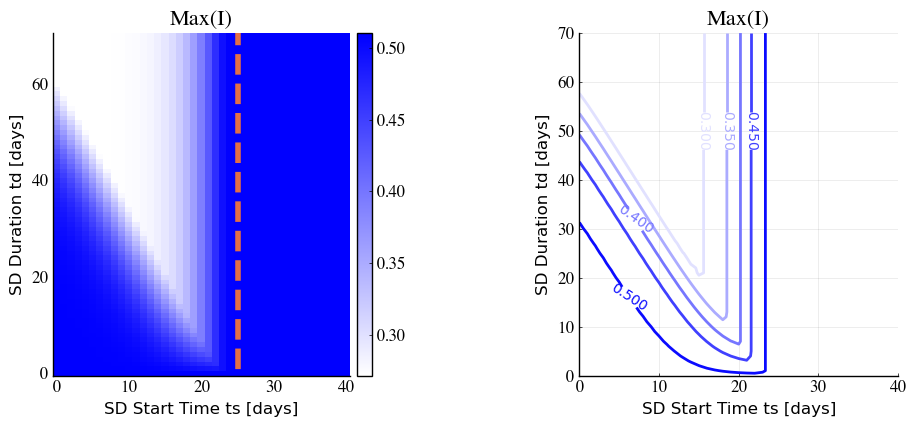

In [6]:
p  = [0.3, 0.15, 0.5, 0.25, 0.1, 0.5, 0.09, 15, 40]

Trng = 0:70
trng = 0:40
data = zeros(size(Trng,1), size(trng,1))
time = data

tspan = (0.0, 1e3)

for i = 1:size(Trng,1)
    for j = 1:size(trng,1)
        # solve the ode problem
        p[8:9] = [trng[j], Trng[i]]
        prob = ODEProblem(SAIR, u0, tspan, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        data[i,j] = maximum(sol[3,:])
    end
end

p1 = heatmap(trng, Trng, data,c=cgrad([:white, :blue]),
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)")
p1 = plot!(p1, [Int(round(timen))], seriestype="vline", line=:dash, linewidth=4, legend=:false)
p1 = bplot(p1, 16)
savefig(p1, "figures/SAIR_heatmap.svg")

p2 = contour(trng, Trng, data,c=cgrad([:white, :blue]), colorbar = false,
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)", contour_labels = true, linewidth=2,
    levels=[0.3, 0.35, 0.40, 0.45, 0.5])
p2 = bplot(p2, 16)
savefig(p2, "figures/SAIR_contour.svg")

fig = plot(p1, p2, layout=(1,2), size=(960,470))
savefig(fig, "figures/SAIR.svg")

# $fSIR$ Model

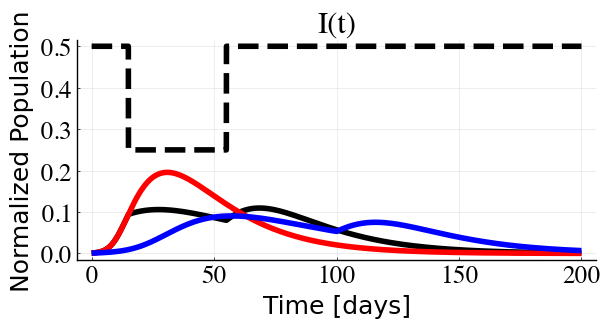

In [7]:
# model description
function fSIR(dx,x,p,t)
    b, db, g, t0, T = p
    k = 10
    u = b - db.*sinput(t, t0, T)
    dx[1] = -u*x[1]*x[2]/(1+k*x[2])
    dx[2] = u*x[1]*x[2]/(1+k*x[2]) - g*x[2]
    dx[3] = g*x[2]
end


# define initial values
u0 = [1-1e-3, 1e-3, 0.]
p  = [beta, bdiff, gamma, 15, 40]

# ode solver
alg = BS3()

# solve the ode problem
tspan = (0.0, 2e2)
prob  = ODEProblem(fSIR, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)

# show something
fig = plot(sol.t, sol[2, :], linewidth=4, xlabel= "Time [days]", c=:black
    , title="I(t)", ylabel= "Normalized Population")

p[4:5] = [0, 0]
prob  = ODEProblem(fSIR, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timen = sol.t[argmax(sol[2,:])]
fig = plot!(fig, sol.t, sol[2, :], linewidth=4, c=:red)

p[4:5] = [0, 100.]
prob  = ODEProblem(fSIR, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timec = sol.t[argmax(sol[2,:])]
fig = plot!(fig, sol.t, sol[2, :], linewidth=4, c=:blue)

# what was the input?
x = 0.:0.01:200
y = 0.5 .- 0.25* sinput.(x, 15, 40)
fig = plot!(fig, x, y, linewidth=4, leg=false, size=(650,370), line=:dash, c=:black)
fig = bplot(fig, 22)

savefig(fig, "figures/fSIR-1d.svg")

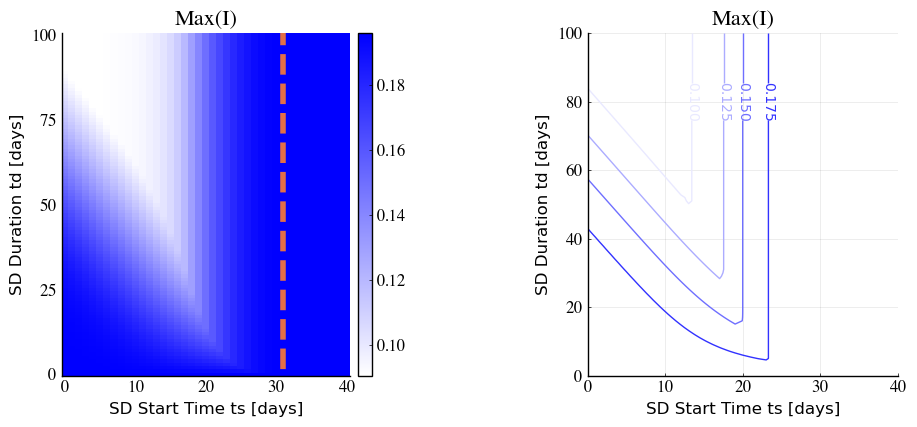

In [8]:
Trng = 0:100
trng = 0:40
data = zeros(size(Trng,1), size(trng,1))
time = data

# define initial values
u0 = [0.999, 0.001, 0.]
tspan = (0.0, 1e3)

for i = 1:size(Trng,1)
    for j = 1:size(trng,1)
        # solve the ode problem
        p[4:5] = [trng[j], Trng[i]]
        prob = ODEProblem(fSIR, u0, tspan, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        data[i,j] = maximum(sol[2,:])
    end
end

p1 = heatmap(trng, Trng, data,c=cgrad([:white, :blue]),
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)")
p1 = plot!(p1, [Int(round(timen))], seriestype="vline", line=:dash, linewidth=4, legend=:false)
p1 = bplot(p1, 16)
savefig(p1, "figures/fSIR_heatmap.svg")

p2 = contour(trng, Trng, data,c=cgrad([:white, :blue]), colorbar = false,
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)", contour_labels = true, linewidth=1,
    levels=[0.10, 0.125, 0.15, 0.175])
p2 = bplot(p2, 16)
savefig(p2, "figures/fSIR_contour.svg")

fig = plot(p1, p2, layout=(1,2), size=(960,470))
savefig(fig, "figures/fSIR.svg")

# 6 Compartment $SIR$ Model

## Basics

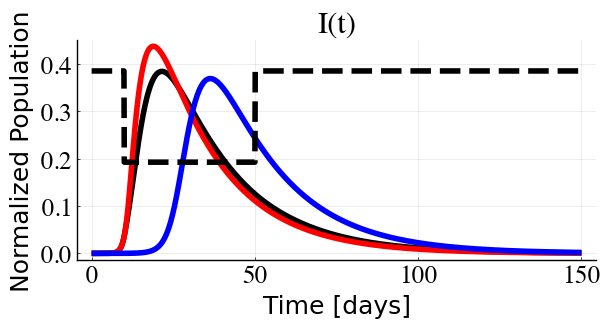

In [9]:
# 6 Compartment SIR model
function ETAL(du,u,p,t)
    ba, ea, es, bi, h, gai, gir, f, d, tc, T = p
    inp1 = ba - 0.5*ba.*sinput(t, tc, T)
    inp2 = bi - 0.5*bi.*sinput(t, tc, T)
    h2 = h
    h1 = 1/(1+10*h2)
    du[1] = -es*inp2*u[1]*u[5] - es*inp1*(u[4]+ea*u[3])*u[1] - h1*u[1] + h2*u[2]
    du[2] = -inp2*u[2]*u[5] - inp1*(u[4]+ea*u[3])*u[2] + h1*u[1] - h2*u[2] 
    du[3] = es*inp2*u[1]*u[5] + es*inp1*(u[4]+ea*u[3])*u[1] + h2*u[4] - gai*u[3] - h1*u[3]
    du[4] = inp2*u[2]*u[5] + inp1*(u[4]+ea*u[3])*u[2] + h1*u[3] - gai*u[4] - h2*u[4]
    du[5] = f*gai*(u[3]+u[4]) - d*u[5] - gir*u[5]
    du[6] = (1-f)*gai*(u[3]+u[4]) + gir*u[5]
end

p  = [1.4, 0.12, 0.12, 2*0.12*1.4, 0, 0.296, 0.048, 0.65, 0.0024, 10, 40]
u0 = [0, 1-1e-5, 0, 0, 1e-5, 0] 

# ode solver
alg = BS3()

# solve the ode problem
tspan = (0.0, 1.5e2)
prob  = ODEProblem(ETAL, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)

# show something
fig = plot(sol.t, sol[5, :], linewidth=4, size=(960, 450), c=:black
    , title = "I(t)", ylabel= "Normalized Population", xlabel= "Time [days]")

p[10:11] = [0., 0.]
prob  = ODEProblem(ETAL, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timen = sol.t[argmax(sol[5,:])]
fig = plot!(fig, sol.t, sol[5, :], linewidth=4, c=:red)

p[10:11] = [0, 1e3]
prob  = ODEProblem(ETAL, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timec = sol.t[argmax(sol[5,:])]
fig = plot!(fig, sol.t, sol[5, :], linewidth=4, c=:blue)

# what was the input?
x = 0.:0.1:1.5e2
y = 0.385 * (1 .- 0.5*sinput.(x, 10, 40))
fig = plot!(fig, x, y, linewidth=4, leg=false, size=(650,370), line=:dash, c=:black)
fig = bplot(fig, 22)

savefig(fig, "figures/6SIR-1d.svg")

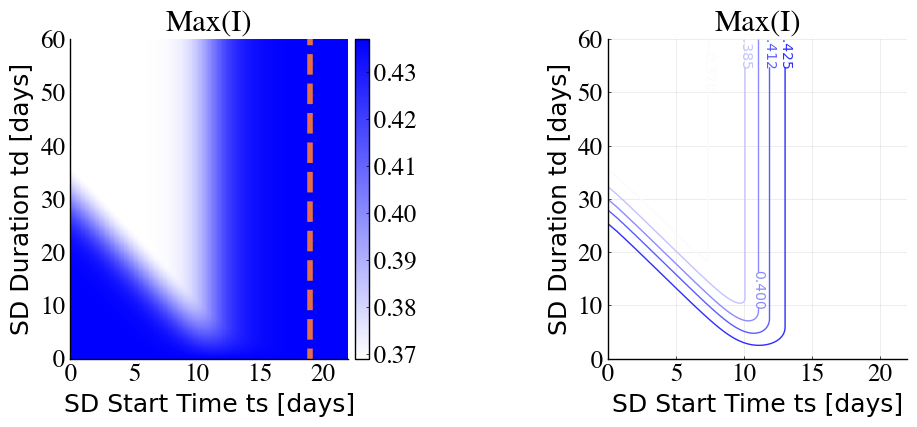

In [10]:
Trng = collect(0:0.1:60)
trng = collect(0:0.1:22)
data = zeros(size(Trng,1), size(trng,1))

# define initial values
u0 = [0, 1-1e-5, 0, 0, 1e-5, 0] 
tspan = (0.0, 1e3)

for i = 1:size(Trng,1)
    for j = 1:size(trng,1)
        # solve the ode problem
        p[10:11] = [trng[j], Trng[i]]
        prob = ODEProblem(ETAL, u0, tspan, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        # find and save the peak
        data[i,j] = maximum(sol[5,:])
    end
end

p1 = heatmap(trng, Trng, data,c=cgrad([:white, :blue]),
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)")
p1 = plot!(p1, [Int(round(timen))], line=:dash, seriestype="vline", linewidth=4, 
            legend=:false)
p1 = plot!(p1, margin=10mm)
p1 = bplot(p1, 22)
savefig(p1, "figures/6SIR_heatmap.svg")
savefig(p1, "figures/6SIR_heatmap.png")

p2 = contour(trng, Trng, data,c=cgrad([:white, :blue]), colorbar = false,
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)", contour_labels = true, linewidth=1,
    levels=[0.37, 0.385, 0.4, 0.4125, 0.425])
p2 = bplot(p2, 22)
savefig(p2, "figures/6SIR_contour.svg")

fig = plot(p1, p2, layout=(1,2), size=(960,470))
savefig(fig, "figures/6SIR.svg")

# $SIQR$

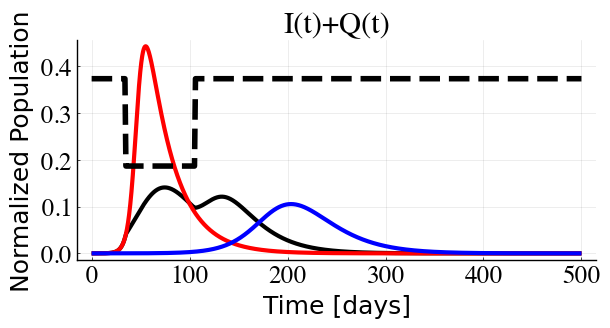

In [11]:
# SIQR model description
function SIQR(du,u,p,t)
    beta, alpha, eta, delta, q, N, t0, T = p
    db = 1-q
    b = beta - beta*db.*sinput(t, t0, T)
    du[1] = -b*u[1]*u[2]/N
    du[2] = b*u[1]*u[2]/N - (alpha+eta)*u[2]
    du[3] = eta*u[2] - delta*u[3]
    du[4] = delta*u[3] + alpha*u[2]
end

# parameters and initial conditions
t0,T = [35, 70]
q, N = [0.5, 1e7]
p  = [0.373, 0.067, 0.067, 0.036, q, N, t0, T]
u0 = [N-83.33, 83.33, 0, 0]

# ode solver
alg = BS3()

# solve the ode problem
tspn = (0., 5e2)
prob = ODEProblem(SIQR, u0, tspn, p)
sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8, saveat=0.1)

# show something
fig = plot(sol.t, sum(sol[2:3,:],dims=1)'/N, linewidth=3, ylab="Normalized Population", xlab="Time [days]"
        , title="I(t)+Q(t)", legend=:topright, c=:black)

p[7:8] = [0., 0.]
prob  = ODEProblem(SIQR, u0, tspn, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timen = sol.t[argmax(sum(sol[2:3,:],dims=1)')]
fig = plot!(fig, sol.t, sum(sol[2:3,:],dims=1)'/N, linewidth=3, c=:red)

p[7:8] = [0, 5e2]
prob  = ODEProblem(SIQR, u0, tspn, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timec = sol.t[argmax(sum(sol[2:3,:],dims=1)')]
fig = plot!(fig, sol.t, sum(sol[2:3,:],dims=1)'/N, linewidth=3, c=:blue)

# what was the input?
x = 0:5e2
y = 0.373 * (1 .- q*sinput.(x, 35, 70))
fig = plot!(fig, x, y, linewidth=4, leg=false, size=(650,370), line=:dash, c=:black)

fig = bplot(fig, 22)
savefig(fig, "figures/SIQR_1d.svg")

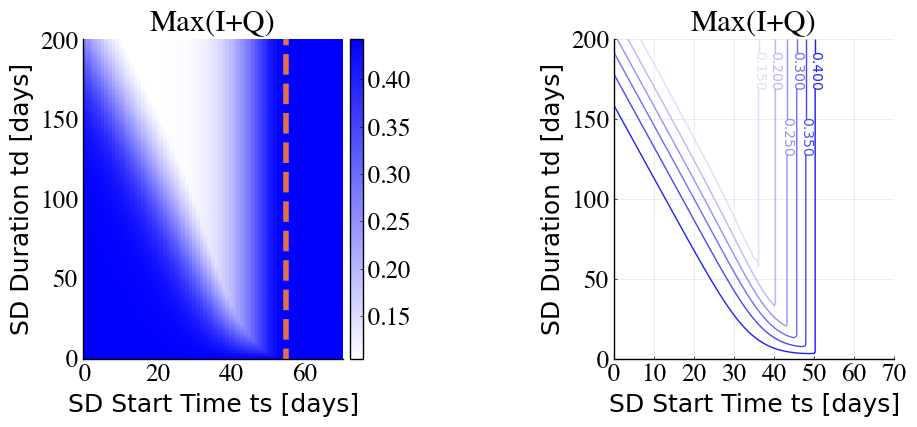

In [12]:
Trng = 0:200
trng = 0:70
data = zeros(size(Trng,1), size(trng,1))

# define initial values
u0 = [N-83.33, 83.33, 0, 0]
tspn = (0.0, 1e3)

for i = 1:size(Trng,1)
    for j = 1:size(trng,1)
        # solve the ode problem
        p[7:8] = [trng[j], Trng[i]]
        prob = ODEProblem(SIQR, u0, tspn, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        # find and save the peak
        data[i,j] = maximum(sum(sol[2:3,:],dims=1)')/N
    end
end

p1 = heatmap(trng, Trng, data,c=cgrad([:white, :blue]),
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I+Q)")
p1 = plot!(p1, [Int(round(timen))], line=:dash, seriestype="vline", linewidth=4, legend=:false)
p1 = bplot(p1, 22)
savefig(p1, "figures/SIQR_heatmap.svg")

p2 = contour(trng, Trng, data,c=cgrad([:white, :blue]), colorbar = false,
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I+Q)", contour_labels = true, linewidth=1,
    levels=[0.15, 0.20, 0.25, 0.30, 0.35, 0.4])
p2 = bplot(p2, 22)
savefig(p2, "figures/SIQR_contour.svg")

fig = plot(p1, p2, layout=(1,2), size=(960,470))
savefig(fig, "figures/SIQR.svg")

# $SIDARTHE$ Model

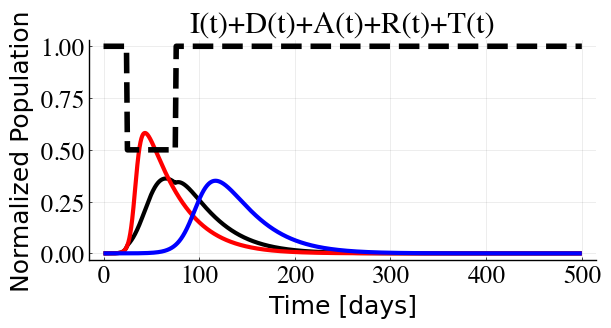

In [13]:
# SIDARHE model description
function SIDARTHE(du,u,p,t)
    beta = p[1]
    s = p[2:17]
    q, N, t0, T = p[18:21]
    db = 1-q
    beta  = beta - db.*sinput(t, t0, T)
    du[1] = -beta*u[1]*(s[1]*u[2]+s[2]*u[3]+s[3]*u[4]+s[4]*u[5])/N
    du[2] = beta*u[1]*(s[1]*u[2]+s[2]*u[3]+s[3]*u[4]+s[4]*u[5])/N - (s[5]+s[6]+s[7])*u[2]
    du[3] = s[5]*u[2] - (s[8]+s[9])*u[3]
    du[4] = s[6]*u[2] - (s[10]+s[11]+s[12])*u[4]
    du[5] = s[8]*u[3] + s[10]*u[4] - (s[13]+s[14])*u[5]
    du[6] = s[11]*u[4] + s[13]*u[5] - (s[15]+s[16])*u[6]
    du[7] = s[7]*u[2] + s[9]*u[3] + s[12]*u[4] + s[14]*u[5] + s[15]*u[6]
    du[8] = s[16]*u[6]
end

# parameters and initial conditions
t0,T = [25, 50]
q, N = [0.5, 1e7]
p  = [1, 0.570, 0.011, 0.456, 0.011, 0.171, 0.371, 0.125, 0.125, 0.012, 
  0.027, 0.003, 0.034, 0.034, 0.017, 0.017, 0.017, q, N, t0, T]
u0 = [N-83.333, 83.333, 0, 0, 0, 0, 0, 0]

# ode solver
alg = BS3()

# solve the ode problem
tspn = (0., 5e2)
prob = ODEProblem(SIDARTHE, u0, tspn, p)
sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8, saveat=0.1)

# I+D+A+R+T: total infected people
fig = plot(sol.t, sum(sol[2:6,:],dims=1)'/N, linewidth=3, title="I(t)+D(t)+A(t)+R(t)+T(t)"
    , ylab="Normalized Population", xlab="Time [days]"
    , legend=:topright, c=:black)

p[20:21] = [0., 0.]
prob  = ODEProblem(SIDARTHE, u0, tspn, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timen = sol.t[argmax(sum(sol[2:6,:],dims=1)')]
fig = plot!(fig, sol.t, sum(sol[2:6,:],dims=1)'/N, linewidth=3, c=:red)

p[20:21] = [0, 5e2]
prob  = ODEProblem(SIDARTHE, u0, tspn, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timec = sol.t[argmax(sum(sol[2:6,:],dims=1)')]
fig = plot!(fig, sol.t, sum(sol[2:6,:],dims=1)'/N, linewidth=3, c=:blue)

# what was the input?
x = 0:5e2
y = 1 .- q*sinput.(x, 25, 50) 
fig = plot!(fig, x, y, linewidth=4, leg=false, size=(650,370), line=:dash, c=:black)
fig = bplot(fig, 22)

savefig(fig, "figures/SIDARTHE_1d.svg")

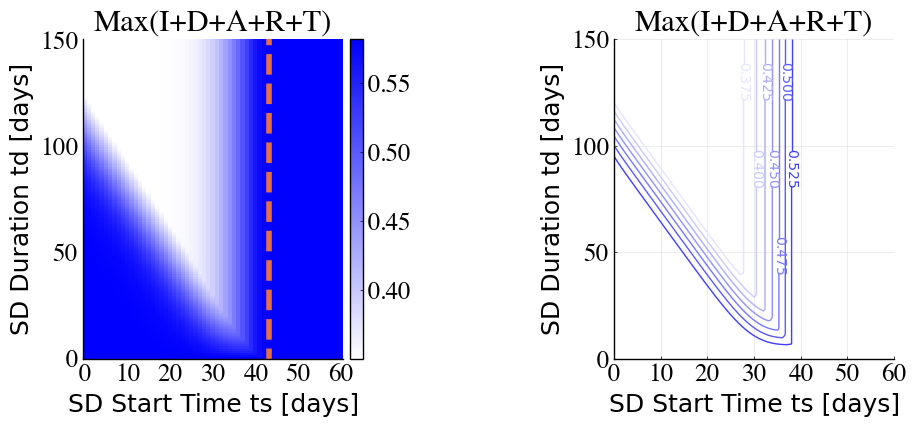

In [14]:
Trng = 0:150
trng = 0:60
data = zeros(size(Trng,1), size(trng,1))

# define initial values
u0 = [N-83.333, 83.333, 0, 0, 0, 0, 0, 0]
tspn = (0.0, 3e3)

for i = 1:size(Trng,1)
    for j = 1:size(trng,1)
        # solve the ode problem
        p[20:21] = [trng[j], Trng[i]]
        prob = ODEProblem(SIDARTHE, u0, tspn, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        # find and save the peak
        data[i,j] = maximum(sum(sol[2:6,:],dims=1)')/N
    end
end

p1 = heatmap(trng, Trng, data,c=cgrad([:white, :blue]),
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I+D+A+R+T)")
p1 = plot!(p1, [Int(round(timen))], line=:dash, seriestype="vline", linewidth=4, legend=:false)
p1 = plot!(p1, margin=10mm)
p1 = bplot(p1, 22)
savefig(p1, "figures/SIDARTHE_heatmap.svg")

p2 = contour(trng, Trng, data,c=cgrad([:white, :blue]), colorbar = false,
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I+D+A+R+T)", contour_labels = true, linewidth=1,
    levels=[0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.525])
p2 = bplot(p2, 22)
savefig(p2, "figures/SIDARTHE_contour.svg")

fig = plot(p1, p2, layout=(1,2), size=(960,470))
savefig(fig, "figures/SIDARTHE.svg")

# Adjourn

In [15]:
using Dates
println("mahdiar")
Dates.format(now(), "Y/U/d HH:MM")  

mahdiar


"2021/February/26 15:57"